### Importing modules

In [1]:
import hoomd
import hoomd.md
import gsd, gsd.hoomd
import plato.draw.vispy as draw
import ipywidgets as widgets
import random
import numpy as np
import matplotlib.pyplot as pp
%gui qt

### Simulation setup

In [2]:
hoomd.context.initialize("")

HOOMD-blue 2.9.7 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 08/09/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


In [3]:
# setting parameters

# number of particles, cube root
# represents number of particles along one side of our 3D box
num_particles_cubert = 10

# lattice constant defines spacing between particles
lattice_const = 3.0

# temperature settings
startTemp = 1.0
endTemp = 0.1

# set simulation length
timeSteps = 1e6

In [4]:
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=lattice_const), n=num_particles_cubert)

c = 0
# randomize velocities based on temperature
for p in system.particles:
    mass = p.mass;
    vx = random.gauss(0, startTemp / mass)
    vy = random.gauss(0, startTemp / mass)
    vz = random.gauss(0, startTemp / mass)
    p.velocity = (vx, vy, vz)
    if c==0:
        print(mass)
        c+=1

notice(2): Group "all" created containing 1000 particles
1.0


In [ ]:
# generate the pair interaction potential

nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

In [ ]:
# set integration parameters

hoomd.md.integrate.mode_standard(dt=0.005)

all = hoomd.group.all()
hoomd.md.integrate.nvt(group=all, 
                       kT=hoomd.variant.linear_interp(points = [(0, startTemp), (timeSteps, endTemp)]), 
                       tau=1.0)

In [ ]:
# record data

# for visualization
hoomd.dump.gsd("dump.gsd", period=timeSteps*1e-2, group=all, overwrite=True)

# for plots
hoomd.analyze.log(filename="dump.log",
                  quantities=['time', 'potential_energy', 'temperature'],
                  period=timeSteps*1e-2,
                  overwrite=True)

In [ ]:
# running simulation

hoomd.run(timeSteps)

### Visualizing simulation

In [5]:
def getFrameCount(fname):
    """
    inputs: fname, the filename (ex: 'dump.gsd')
    outputs: len(traj), number of frames in simulation
    """
    with gsd.hoomd.open(fname, 'rb') as traj:
        return len(traj)

In [6]:
filename = 'dump.gsd'
frame_num = getFrameCount(filename)

In [7]:
# function for centering droplet
def centercrystal(simulationbox,particlepositions):
    """
    Recentering the positions of all particles relative to COM, because otherwise they are split across the "box"
    Algorithm projects points along 3 orthogonal cylinders, finds COM, projects back into real space
    Useful resource w/ similar algorithm: https://www.cs.drexel.edu/~david/Papers/Bai_JGT.pdf
    
    inputs:
    simulationbox= 6x1 array of the box dimensions [Lx Ly Lz xy xz yz]
    particlepositions= the positions of the particles from the snapshot, #particles x 3 dimensions (xyz) array
    
    """    
    #center particles
    simbox=[simulationbox[3]-simulationbox[0], simulationbox[4]-simulationbox[1], simulationbox[5]-simulationbox[2]]
    theta = (particlepositions / simbox + .5) * 2 * np.pi
    sums = np.sum(np.exp(1j * theta), axis = 0)
    fractions = np.angle(sums) / 2 / np.pi
    fractions %= 1.
    fractions -= .5
    delta = fractions * simbox
    pos_CM=np.copy(particlepositions)
    pos_CM[:] -= delta[np.newaxis, :]
    
    # wrap particles back into box
    pos_CM[pos_CM[:, 0] > simulationbox[0]/2] -= [simulationbox[0], 0, 0]
    pos_CM[pos_CM[:, 1] > simulationbox[1]/2] -= [0, simulationbox[1], 0]
    pos_CM[pos_CM[:, 2] > simulationbox[2]/2] -= [0, 0, simulationbox[2]]
    pos_CM[pos_CM[:, 0] < -simulationbox[0]/2] += [simulationbox[0], 0, 0]
    pos_CM[pos_CM[:, 1] < -simulationbox[1]/2] += [0, simulationbox[1], 0]
    pos_CM[pos_CM[:, 2] < -simulationbox[2]/2] += [0, 0, simulationbox[2]]
    
    return pos_CM

In [8]:
prim = draw.Spheres()
box_prim = draw.Box(color=(0, 0, 0, 1), width=.2) #box
scene = draw.Scene([prim, box_prim], zoom=.5, clip_scale=5) #box
#scene = draw.Scene(prim) # no box
scene.show()

# looping over frames
@widgets.interact(frame_index=(0, frame_num-1, 1))
def plot(frame_index=0):
    with gsd.hoomd.open(filename, 'rb') as traj:
        frame = traj[frame_index]
        box = frame.configuration.box
        for (name, val) in zip(['Lx', 'Ly', 'Lz', 'xy', 'xz', 'yz'], box):
            setattr(box_prim, name, val)  
        
        # grabbing particle positions and diameters from simulation file
        prim.positions = centercrystal(box, frame.particles.position)
        #prim.positions = frame.particles.position
        prim.diameters = np.full(len(frame.particles.position), 1)
        
        # setting particle colors
        colors = np.ones((len(prim.positions), 4))
        colors[:, :3] = np.float32(np.divide([255, 50, 150], 255)) #pink
        prim.colors = colors
    scene.render()

VispyWidget(height=600, width=800)

interactive(children=(IntSlider(value=0, description='frame_index', max=99), Output()), _dom_classes=('widget-…

### Plotting simulation data over time

In [9]:
data = np.genfromtxt(fname='dump.log', skip_header=True);

Text(0, 0.5, 'potential energy')

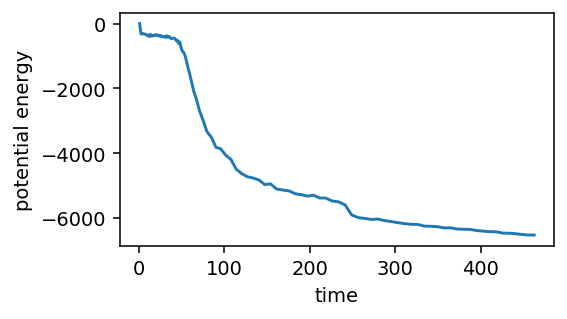

In [10]:
pp.figure(figsize=(4,2.2), dpi=140)
pp.plot(data[:,1], data[:,2])
pp.xlabel('time')
pp.ylabel('potential energy')

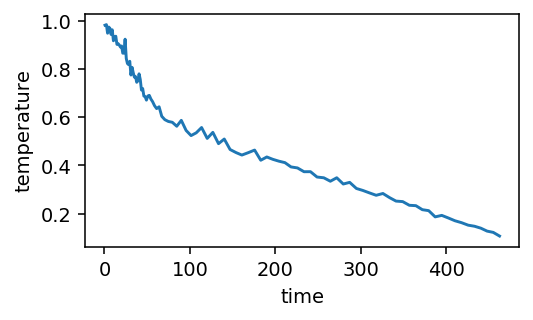

In [11]:
pp.figure(figsize=(4,2.2), dpi=140);
pp.plot(data[:,1], data[:,3]);
pp.xlabel('time');
pp.ylabel('temperature');